## Using Natural Language Processing Techniques to Understand Corporate Sustainability Issues

by Jenica Andersen

In [1]:
#Necessary imports! (Is any of this REALLY necessary??)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import nltk
#nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.util import ngrams
from nltk.corpus import stopwords, wordnet
from nltk.stem import LancasterStemmer, PorterStemmer, SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
# Bring on the Corporate sustainability shareholder resolution data!
#These were obtained manually from https://engagements.ceres.org/?_ga=2.193001133.1671682996.1654368102-1475954746.1654368096
#The resolutions span 2019-2022

df = pd.read_csv(r'shareholder_resolutions_ceres2.csv')
#isolate corpus, perform NLP on the column titled "whereas" (all resolutions begin with Whereas)
text = df.whereas
print(text)

0      In our Company’s 2021 Sustainability Report, C...
1      We believe in full disclosure of Abbott Labora...
2      The political expenditures of AbbVie Inc. appe...
3      Resolved:\nShareholders request Air Products a...
4      The increasing rate and number of climate rela...
                             ...                        
937    Resolved:\nShareholders request that Mondelēz ...
938    Resolved: Shareholders of Mondelez Internation...
939    we believe in full disclosure of Morgan Stanle...
940    Motorola Solutions, Inc., a global corporation...
941    we believe in full disclosure of Motorola Solu...
Name: whereas, Length: 942, dtype: object


In [3]:
df.info()
#there are some null fields. Remove those

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   status        942 non-null    object
 1   title         942 non-null    object
 2   organization  942 non-null    object
 3   filed_by      940 non-null    object
 4   year          942 non-null    int64 
 5   whereas       923 non-null    object
dtypes: int64(1), object(5)
memory usage: 44.3+ KB


In [4]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 921 entries, 0 to 941
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   status        921 non-null    object
 1   title         921 non-null    object
 2   organization  921 non-null    object
 3   filed_by      921 non-null    object
 4   year          921 non-null    int64 
 5   whereas       921 non-null    object
dtypes: int64(1), object(5)
memory usage: 50.4+ KB


In [5]:
#take a look at how many words we've got in the corpus. The more words we have, the more robust the results.
word_count = df["whereas"].apply(lambda x: len(str(x).split(' ')))
word_count.sum()

407416

In [11]:
#Use regex to remove the special characters from the text column, creating a new column called "preprocessed"
df['preprocessed'] = df.whereas.apply(lambda x: (re.sub(r"[^a-zA-Z0-9 ]", " ", x)))
#and remove stand-alone numbers from the preprocessed column
df['preprocessed'] = df.preprocessed.apply(lambda x: (re.sub(r'[0-9]', ' ', x)))
#make all words lowercase
df['preprocessed'] = df['preprocessed'].str.lower()
df.head()

,status,title,organization,filed_by,year,whereas,preprocessed
0,Filed,Adopt stewardship practices to reduce diversif...,3M Co.,The Shareholder Commons,2022,"In our Company’s 2021 Sustainability Report, C...",in our company s sustainability report c...
1,Vote,Report on lobbying,Abbott Laboratories,Unitarian Universalist Association,2022,We believe in full disclosure of Abbott Labora...,we believe in full disclosure of abbott labora...
2,Vote,Report on lobbying in line with company values...,AbbVie Inc.,As You Sow,2022,The political expenditures of AbbVie Inc. appe...,the political expenditures of abbvie inc appe...
3,Withdrawn: Commitment,Adopt GHG reduction targets,Air Products & Chemicals Inc.,The Nathan Cummings Foundation,2022,Resolved:\nShareholders request Air Products a...,resolved shareholders request air products ad...
4,Withdrawn: Strategic,Adopt GHG reduction targets,Allegheny Technologies Inc.,As You Sow,2022,The increasing rate and number of climate rela...,the increasing rate and number of climate rela...


In [12]:
#Now begin to remove stopwords. Some words appear in the results but do not contribute significantly to interpretations. 
#Make custom list of words to remove, in addition to the common, English stop words.
my_additional_stop_words = ['www', 'whereas', 'include', 'full', 'request', 'resolved',
                            'shareholder','shareholders', 
                            'company', 'companies','use', #'In', 'We', '"We', '"A"', 'The', 'Our', 'For', 
                            'https', 'http', 'pdf', '"I"', 'one', #'abebafb'
                           ]

stop_words = stopwords.words('english')
stop_words2 = list(stop_words)

for word in my_additional_stop_words:
    stop_words2.append(word)

In [14]:
#now create a column with stop words removed    
df['filtered'] = df.preprocessed.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words2)]))
df.sample(5)

,status,title,organization,filed_by,year,whereas,preprocessed,filtered
894,Withdrawn: Commitment,Publish sustainability report,Host Hotels & Resorts Inc.,Illinois State Treasurer,2019,Shareholders request that Host Hotels & Resort...,shareholders request that host hotels resort...,host hotels resorts issue annual sustainabilit...
428,Vote,Report on opioid crisis,Johnson & Johnson,Bright Start College Savings Trust,2020,"RESOLVED, that shareholders of Johnson & Johns...",resolved that shareholders of johnson johns...,johnson johnson jnj urge board directors board...
876,Vote,Adopt board oversight of workplace sexual hara...,XPO Logistics Inc,Service Employees International Union,2019,Resolved: That shareholders of XPO Logistics (...,resolved that shareholders of xpo logistics ...,xpo logistics xpo urge board directors strengt...
190,Withdrawn: Commitment,Report on 2-degree analysis and strategy,CarMax Inc.,Green Century Capital Management,2021,"In 2018, the Intergovernmental Panel on Climat...",in the intergovernmental panel on climat...,intergovernmental panel climate change advised...
495,Vote,Review and report on ESG proxy voting,"T. Rowe Price Group, Inc.",Zevin Asset Management,2020,T. Rowe Price Group is a respected leader in t...,t rowe price group is a respected leader in t...,rowe price group respected leader financial se...


In [16]:
#create a list of the preprocessed and filtered documents for further topic modeling
corpus = list(df.filtered)
#Make sure it is a list, then check its length to be sure the corpus is a list of documents (not all words or letters handled individually)
type(corpus)
len(corpus)

list

In [17]:
#Name the stemmers. I will explore all three. 
#After exploring all three, the Porter stemmer was used in the results. Seems the least aggressive. The Lancaster and Snowball stemmer dtms are further below.
porter = PorterStemmer()
snowball = SnowballStemmer(language = 'english')
lancaster = LancasterStemmer()

In [19]:
#tokenize the filtered column before stemming
df['tokenized'] = df.filtered.apply(lambda x: RegexpTokenizer("\s+", gaps=True).tokenize(x))#' '.join([word for word in x.split() if word not in (stop_words2)]).porter.stem(x))
#create a column for each stemmer method
df['porter'] = df['tokenized'].apply(lambda x: [porter.stem(y) for y in x]) # Stem every word.
df['lancaster'] = df['tokenized'].apply(lambda x: [lancaster.stem(y) for y in x]) # Stem every word.
df['snowball'] = df['tokenized'].apply(lambda x: [snowball.stem(y) for y in x]) # Stem every word.
df.head()

,status,title,organization,filed_by,year,whereas,preprocessed,filtered,tokenized,porter,lancaster,snowball
0,Filed,Adopt stewardship practices to reduce diversif...,3M Co.,The Shareholder Commons,2022,"In our Company’s 2021 Sustainability Report, C...",in our company s sustainability report c...,sustainability report ceo mike roman states co...,"[sustainability, report, ceo, mike, roman, sta...","[sustain, report, ceo, mike, roman, state, com...","[sustain, report, ceo, mik, rom, stat, commit,...","[sustain, report, ceo, mike, roman, state, com..."
1,Vote,Report on lobbying,Abbott Laboratories,Unitarian Universalist Association,2022,We believe in full disclosure of Abbott Labora...,we believe in full disclosure of abbott labora...,believe disclosure abbott laboratories abbott ...,"[believe, disclosure, abbott, laboratories, ab...","[believ, disclosur, abbott, laboratori, abbott...","[believ, disclos, abbot, lab, abbot, direct, i...","[believ, disclosur, abbott, laboratori, abbott..."
2,Vote,Report on lobbying in line with company values...,AbbVie Inc.,As You Sow,2022,The political expenditures of AbbVie Inc. appe...,the political expenditures of abbvie inc appe...,political expenditures abbvie inc appear misal...,"[political, expenditures, abbvie, inc, appear,...","[polit, expenditur, abbvi, inc, appear, misali...","[polit, expendit, abbvy, int, appear, misalign...","[polit, expenditur, abbvi, inc, appear, misali..."
3,Withdrawn: Commitment,Adopt GHG reduction targets,Air Products & Chemicals Inc.,The Nathan Cummings Foundation,2022,Resolved:\nShareholders request Air Products a...,resolved shareholders request air products ad...,air products address risks opportunities prese...,"[air, products, address, risks, opportunities,...","[air, product, address, risk, opportun, presen...","[air, produc, address, risk, opportun, pres, c...","[air, product, address, risk, opportun, presen..."
4,Withdrawn: Strategic,Adopt GHG reduction targets,Allegheny Technologies Inc.,As You Sow,2022,The increasing rate and number of climate rela...,the increasing rate and number of climate rela...,increasing rate number climate related disaste...,"[increasing, rate, number, climate, related, d...","[increas, rate, number, climat, relat, disast,...","[increas, rat, numb, clim, rel, disast, affect...","[increas, rate, number, climat, relat, disast,..."


In [20]:
#RUN THIS ONLY ONE TIME to unnest the list in each doc--running it more than once will tokenize the individual letters

df['porter'] = df['porter'].apply(lambda x: ' '.join([word for word in x]))
df['lancaster'] = df['lancaster'].apply(lambda x: ' '.join([word for word in x]))
df['snowball'] = df['snowball'].apply(lambda x: ' '.join([word for word in x]))
df

,status,title,organization,filed_by,year,whereas,preprocessed,filtered,tokenized,porter,lancaster,snowball
0,Filed,Adopt stewardship practices to reduce diversif...,3M Co.,The Shareholder Commons,2022,"In our Company’s 2021 Sustainability Report, C...",in our company s sustainability report c...,sustainability report ceo mike roman states co...,"[sustainability, report, ceo, mike, roman, sta...",sustain report ceo mike roman state commit lea...,sustain report ceo mik rom stat commit lead su...,sustain report ceo mike roman state commit lea...
1,Vote,Report on lobbying,Abbott Laboratories,Unitarian Universalist Association,2022,We believe in full disclosure of Abbott Labora...,we believe in full disclosure of abbott labora...,believe disclosure abbott laboratories abbott ...,"[believe, disclosure, abbott, laboratories, ab...",believ disclosur abbott laboratori abbott dire...,believ disclos abbot lab abbot direct indirect...,believ disclosur abbott laboratori abbott dire...
2,Vote,Report on lobbying in line with company values...,AbbVie Inc.,As You Sow,2022,The political expenditures of AbbVie Inc. appe...,the political expenditures of abbvie inc appe...,political expenditures abbvie inc appear misal...,"[political, expenditures, abbvie, inc, appear,...",polit expenditur abbvi inc appear misalign pub...,polit expendit abbvy int appear misalign publ ...,polit expenditur abbvi inc appear misalign pub...
3,Withdrawn: Commitment,Adopt GHG reduction targets,Air Products & Chemicals Inc.,The Nathan Cummings Foundation,2022,Resolved:\nShareholders request Air Products a...,resolved shareholders request air products ad...,air products address risks opportunities prese...,"[air, products, address, risks, opportunities,...",air product address risk opportun present clim...,air produc address risk opportun pres clim cha...,air product address risk opportun present clim...
4,Withdrawn: Strategic,Adopt GHG reduction targets,Allegheny Technologies Inc.,As You Sow,2022,The increasing rate and number of climate rela...,the increasing rate and number of climate rela...,increasing rate number climate related disaste...,"[increasing, rate, number, climate, related, d...",increas rate number climat relat disast affect...,increas rat numb clim rel disast affect socy c...,increas rate number climat relat disast affect...
...,...,...,...,...,...,...,...,...,...,...,...,...
937,Vote,Report on supply chain deforestation impacts,"Mondelez International, Inc.",SumOfUS,2019,Resolved:\nShareholders request that Mondelēz ...,resolved shareholders request that mondel z i...,mondel z international inc mondelez report ann...,"[mondel, z, international, inc, mondelez, repo...",mondel z intern inc mondelez report annual ini...,mondel z intern int mondelez report an init ma...,mondel z intern inc mondelez report annual ini...
938,Vote,Report on pay disparity,"Mondelez International, Inc.",AFL-CIO,2019,Resolved: Shareholders of Mondelez Internation...,resolved shareholders of mondelez internation...,mondelez international inc compensation commit...,"[mondelez, international, inc, compensation, c...",mondelez intern inc compens committe board dir...,mondelez intern int compens commit board direc...,mondelez intern inc compens committe board dir...
939,Vote,Report on lobbying,Morgan Stanley,"Boston Common Asset Management, LLC",2019,we believe in full disclosure of Morgan Stanle...,we believe in full disclosure of morgan stanle...,believe disclosure morgan stanley direct indir...,"[believe, disclosure, morgan, stanley, direct,...",believ disclosur morgan stanley direct indirec...,believ disclos morg stanley direct indirect lo...,believ disclosur morgan stanley direct indirec...
940,Vote,Nominate human rights expert to board,"Motorola Solutions, Inc.",Episcopal Church,2019,"Motorola Solutions, Inc., a global corporation...",motorola solutions inc a global corporation...,motorola solutions inc global corporation face...,"[motorola, solutions, inc, global, corporation..

### Word Cloud

This is a visualization plugin that uses word frequency to determine size of a word. In a wordcloud, we can see more about word frequency within the corpus

In [23]:
#create a wordcloud from the three stemmed columns (only one is necessary. I'm being curious)
text_port = " ".join(word for word in df.porter)
word_cloud_port = WordCloud(collocations = False, background_color = 'white').generate(text)

text_lanc = " ".join(word for word in df.lancaster)
word_cloud_lanc = WordCloud(collocations = False, background_color = 'white').generate(text_lanc)

text_snow = " ".join(word for word in df.snowball)
word_cloud_snow = WordCloud(collocations = False, background_color = 'white').generate(text_snow)

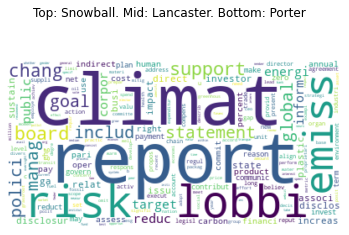

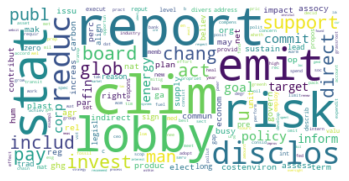

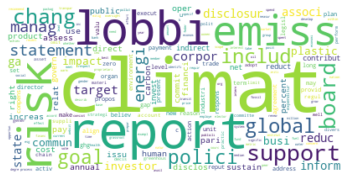

In [33]:
#plot the wordclouds together
stem = (word_cloud_snow,word_cloud_lanc,word_cloud_port)
fig = plt.figure()
fig.suptitle('Top: Snowball. Mid: Lancaster. Bottom: Porter')
for s in (stem):
    plt.imshow(s, interpolation='bilinear')
    plt.axis("off")
    plt.show()
#first plot is snowball, second is lancaster, third is porter

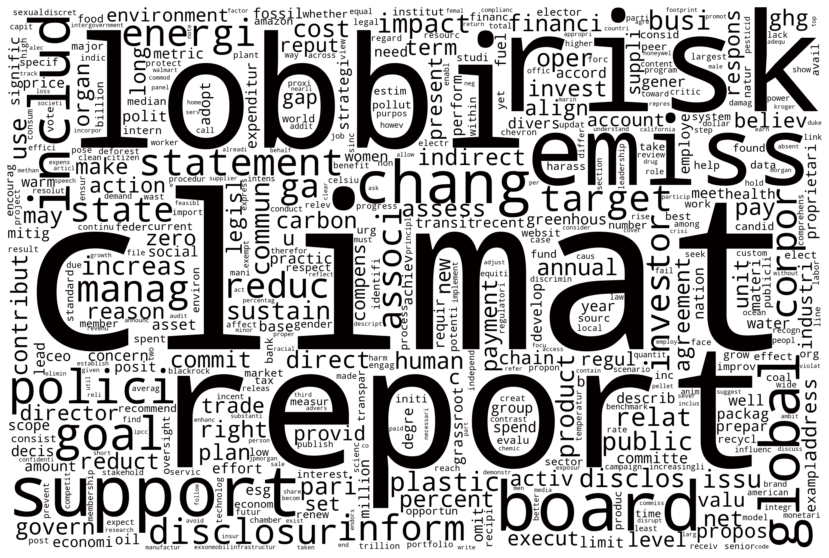

In [34]:
#this visualization formatting code was shared with me by Leaha Nagy, a fellow Metis data scientist.
#The porter stemmer is used
# change the value to black
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")
# set the wordcloud background color to white
# set max_words to 1000
# set width and height to higher quality, 3000 x 2000
word_cloud = WordCloud(collocations = False, background_color = 'white',width=3000, height=2000, max_words=500).generate(text_port)
#wordcloud = WordCloud(font_path = '/Library/Fonts/Arial Unicode.ttf', background_color="white", width=3000, height=2000, max_words=500).generate_from_frequencies(df['porter'])
# set the word color to black
word_cloud.recolor(color_func = black_color_func)
# set the figsize
plt.figure(figsize=[15,10])
# plot the wordcloud
plt.imshow(word_cloud, interpolation="bilinear")
# remove plot axes
plt.axis("off")
# save the image
plt.savefig('word_cloud_all.png')

## Document Term Matrix (dtm)

This is a matrix that counts the number of times each word is used in a document. The dtm is then used with non-negative matrix factorization (nmf) for topic modeling. 

In [35]:
#create a list of the stemmed series, for use in the countvectorizer
corpus_port = list(df.porter)
corpus_lanc = list(df.lancaster)
corpus_snow = list(df.snowball)

In [36]:
#this code uses the first 100 characters from the resolution title as the index for the dataframe--this aids with interpretability
indx_label = [e[:100]+"..." for e in df.title]

In [37]:
#Some calculations regarding max term inclusion
921*.99

911.79

In [39]:
#countvectorizer creates the dtm. Here I use the porter stemmed corpus
#with min_df = 6 I am excluding terms that occur in more than 6 documents (this got rid of the name Zuckerberg, an arbitrary but effective cutoff),
#with max_df = .99, I am excluding terms that occur in more than 99% of the documents (which is about 912 documents). This is conservative and could be more aggressive

#ngrams explored here include uni-gram, bi-gram, and tri-gram. I want to see if words used in proximity occur at great enough 
#frequency to be significant. 

#I'm also removing any stop words via countvectorizer that made it through the earlier regex stop word removal

cv = CountVectorizer(stop_words = 'english', min_df = 6, max_df = .99, ngram_range=(1, 3))
#using the porter stemmed data for the dtm
X_port = cv.fit_transform(corpus_port)
dtm_port = pd.DataFrame(X_port.toarray(), index=indx_label, columns=cv.get_feature_names_out())
dtm_port

,ab,abandon,abbvi,abil,abil compet,abil compet adapt,abil comprehens,abil comprehens evalu,abl,abl fulli,...,zero limit warm,zero maintain,zero maintain warm,zero net,zero net deforest,zero order,zero order limit,zero pathway,zero scenario,zero target
Adopt stewardship practices to reduce diversified portfolio ESG costs...,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Report on lobbying...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Report on lobbying in line with company values/policy...,0,0,12,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Adopt GHG reduction targets...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Adopt GHG reduction targets...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Report on supply chain deforestation impacts...,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Report on pay disparity...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Report on lobbying...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Nominate human rights expert to board...,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
#take a look at features names and tune cv parameters if desired
cv.get_feature_names()

/Users/vesper/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['ab',
 'abandon',
 'abbvi',
 'abil',
 'abil compet',
 'abil compet adapt',
 'abil comprehens',
 'abil comprehens evalu',
 'abl',
 'abl fulli',
 'abl fulli evalu',
 'abroad',
 'abroad spend',
 'abroad spend lobbi',
 'absenc',
 'absent',
 'absent exampl',
 'absent state',
 'absent studi',
 'absolut',
 'absolut elimin',
 'absolut elimin ton',
 'absolut emiss',
 'absolut emiss energi',
 'absolut emiss reduct',
 'absolut net',
 'absolut net energi',
 'absorb',
 'absorb toxic',
 'absorb toxin',
 'absorb toxin dioxin',
 'abus',
 'academ',
 'academ studi',
 'academi',
 'academi pediatr',
 'acceler',
 'accept',
 'accept platform',
 'accept platform suggest',
 'access',
 'access person',
 'access person document',
 'access pipelin',
 'accompani',
 'accomplish',
 'accord',
 'accord american',
 'accord bank',
 'accord bank climat',
 'accord believ',
 'accord best',
 'accord best avail',
 'accord bloomberg',
 'accord bloomberg new',
 'accord california',
 'accord california transpar',
 'accord gen

## NMF

Here the words in the corpus will be clusterd into use groups. Then I will choose a lable or "topic" for each cluster. This is the topic modeling step.

In [52]:
#A paper on a similar project by Raghupathi et al. (Sustainability, 2020) used 7 key topics, based on k-means clustering. 
#Through trial and error, this seems like a good number for me. Beyond 7 topics, I see repetition. Below seven, some significant topics/terms are omitted 

#A NEXT STEP! I would like to use nmf coherence score to optimize the number of topics. Initiallize with nndsvda
#nndsvda = non negative double singular value decomposition is a new method designed to enhance the initialization stage of the nonnegative matrix factorization. The basic algorithm contains no randomization and is based on two SVD processes, one approximating the data matrix, the other approximating positive sections of the resulting partial SVD factors utilizing an algebraic property of unit rank matrices.
#NNDSVD is well suited to initialize NMF algorithms with sparse factors. Numerical examples suggest that NNDSVD leads to rapid reduction of the approximation error of many NMF algorithms. By setting algorithm options :param:`flag` dense factors can be generated.

nmf = NMF(7, init = "nndsvda") 
nmf.fit(dtm_port)

NMF(init='nndsvda', n_components=7)

In [53]:
#now create the topic-term-matrix, with three significant digits.
topic_term = nmf.components_.round(3)
topic_term.shape

(7, 15040)

In [54]:
#and turn it into a dataframe with topic cluster as rows, and terms as columns
topic_term_df = pd.DataFrame(topic_term, columns = cv.get_feature_names_out())
topic_term_df

,ab,abandon,abbvi,abil,abil compet,abil compet adapt,abil comprehens,abil comprehens evalu,abl,abl fulli,...,zero limit warm,zero maintain,zero maintain warm,zero net,zero net deforest,zero order,zero order limit,zero pathway,zero scenario,zero target
0,0.010,0.004,0.095,0.261,0.086,0.086,0.07,0.07,0.073,0.000,...,0.000,0.000,0.000,0.017,0.017,0.000,0.000,0.002,0.017,0.000
1,0.003,0.000,0.158,0.033,0.000,0.000,0.00,0.00,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.001,0.000,0.000,0.000,0.000,0.00,0.00,0.002,0.000,...,0.000,0.001,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.002
3,0.000,0.000,0.006,0.000,0.000,0.000,0.00,0.00,0.091,0.082,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.009,0.002,0.000,0.023,0.000,0.000,0.00,0.00,0.000,0.000,...,0.000,0.003,0.003,0.003,0.003,0.000,0.000,0.000,0.000,0.000
5,0.001,0.004,0.000,0.084,0.000,0.000,0.00,0.00,0.006,0.000,...,0.000,0.000,0.000,0.012,0.012,0.000,0.000,0.001,0.000,0.000
6,0.011,0.029,0.000,0.000,0.000,0.000,0.00,0.00,0.008,0.000,...,0.062,0.032,0.032,0.003,0.003,0.031,0.026,0.034,0.033,0.250


In [55]:
# This function displays the top n terms in each topic--this code is from Metis course material

def display_topics(model, feature_names, no_top_words, topic_names = None): 
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix + 1)
        else:
            print("\nTopic: ", topic_names[ix])
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    print("\n")
    return model, feature_names, no_top_words

In [56]:
output = display_topics(nmf, cv.get_feature_names_out(), 10)


Topic  1
report, sustain, risk, board, manag, esg, execut, polici, corpor, issu

Topic  2
lobbi, commun, payment, legisl, indirect, direct, grassroot, indirect lobbi, grassroot lobbi, direct indirect

Topic  3
pay, gap, pay gap, percent, median, women, report, gender, unit, gender pay

Topic  4
corpor, elector, spend, polit, contribut, support, includ, board, elect, expenditur

Topic  5
plastic, packag, recycl, reduc, report, pollut, plastic packag, ocean, plastic pollut, product

Topic  6
right, human, human right, risk, impact, assess, busi, chain, labor, oper

Topic  7
climat, emiss, target, chang, energi, climat chang, goal, ga, risk, global




In [58]:
#now apply my own labels to the topic clusters, and show top 5 terms per topic
display_topics(nmf, cv.get_feature_names_out(), 5, [
    '1. ESG Management and Corporate Policies', 
    '2. Activism/Lobbying', 
    '3. Female Wage Disparity',
    '4. Campaign Contributions', 
    '5. Plastic Pollution, Recycling and the Ocean',
    '6. Human Rights Impact Assessments', 
    '7. Climate Emissions Goals'
]);

# when more topics are included, some that show up (after the first topic has repeated a few times) are:
#    '9. Financing fossil fuels/warming/ ',
#    '10. Compensation reviews for ceos and employees',
#    '14. water use and management',
#    '16. natural gas and liquified natural gas, methane and emissions',
#    '17. plastic pellets polution, chemical spills',
#    '18. corporate leaders and accountability',
#    '19. gender diversity in tech',
#    '20. sexual harassment reporting',
# Human labor and the supply chain
# Green house gas net zero
# renewable energy climate change goals
# paris climate agreement
# deforestation, supply chain risks
# drug prices (for seniors)
# plant based proteins, heinz and kraft
# sexual harassment reporting
# water risks and plastic pellets



Topic:  1. ESG Management and Corporate Policies
report, sustain, risk, board, manag

Topic:  2. Activism/Lobbying
lobbi, commun, payment, legisl, indirect

Topic:  3. Female Wage Disparity
pay, gap, pay gap, percent, median

Topic:  4. Campaign Contributions
corpor, elector, spend, polit, contribut

Topic:  5. Plastic Pollution, Recycling and the Ocean
plastic, packag, recycl, reduc, report

Topic:  6. Human Rights Impact Assessments
right, human, human right, risk, impact

Topic:  7. Climate Emissions Goals
climat, emiss, target, chang, energi




In [59]:
#now create the document-topic matrix for the porter stemmed terms(earlier we had the nmf topic-term matrix)
doc_topic = nmf.transform(dtm_port)
doc_topic.shape

(921, 7)

In [60]:
#and turn it into a dataframe for further use and interpretability
#The higher the score, the more the topic label/category fits the document

doc_topic_df = pd.DataFrame(doc_topic.round(5), index = indx_label, columns = [
    '1. ESG Management and Corporate Policies', 
    '2. Activism/Lobbying', 
    '3. Female Wage Disparity',
    '4. Campaign Contributions', 
    '5. Plastic Pollution, Recycling and the Ocean',
    '6. Human Rights Impact Assessments', 
    '7. Climate Emissions Goals' 
])
doc_topic_df

,1. ESG Management and Corporate Policies,2. Activism/Lobbying,3. Female Wage Disparity,4. Campaign Contributions,"5. Plastic Pollution, Recycling and the Ocean",6. Human Rights Impact Assessments,7. Climate Emissions Goals
Adopt stewardship practices to reduce diversified portfolio ESG costs...,0.52465,0.04145,0.02893,0.00000,0.08302,0.07423,0.16320
Report on lobbying...,0.03923,1.45791,0.00798,0.00722,0.02065,0.00000,0.00000
Report on lobbying in line with company values/policy...,0.22388,0.17386,0.06527,0.23761,0.02631,0.09325,0.14627
Adopt GHG reduction targets...,0.00000,0.00000,0.00000,0.00000,0.00089,0.03061,0.38157
Adopt GHG reduction targets...,0.00000,0.00000,0.00000,0.00000,0.00129,0.00000,1.15895
...,...,...,...,...,...,...,...
Report on supply chain deforestation impacts...,0.24311,0.03586,0.02015,0.06755,0.07780,0.36881,0.21786
Report on pay disparity...,0.40937,0.00000,0.70902,0.00000,0.00000,0.00000,0.00000
Report on lobbying...,0.00000,2.08913,0.06252,0.00000,0.00000,0.00000,0.00000
Nominate human rights expert to board...,0.20168,0.00000,0.00000,0.11613,0.00000,1.20810,0.00000


In [61]:
#this code from stackexchange

# find the column name of maximum values in every row
maxValueIndex = doc_topic_df.idxmax(axis = 1)
 
maxValueIndex_df = pd.DataFrame(maxValueIndex, columns=['topic'])
maxValueIndex_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 921 entries, Adopt stewardship practices to reduce diversified portfolio ESG costs... to Report on lobbying...
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   topic   921 non-null    object
dtypes: object(1)
memory usage: 14.4+ KB


In [62]:
#now we have a dataframe with (first 100 characters of ) resolution titles and the best topic label for that resolution
maxValueIndex_df.head(50)
#not a perfect match in every instance. This can be fine-tuned by further adjusting the number of topics during nmf
#optimizing the number of terms would be beneficial here

,topic
Adopt stewardship practices to reduce diversified portfolio ESG costs...,1. ESG Management and Corporate Policies
Report on lobbying...,2. Activism/Lobbying
Report on lobbying in line with company values/policy...,4. Campaign Contributions
Adopt GHG reduction targets...,7. Climate Emissions Goals
Adopt GHG reduction targets...,7. Climate Emissions Goals
Report on benefits of product repair...,6. Human Rights Impact Assessments
Report on water use risks...,1. ESG Management and Corporate Policies
Report on ESG risks to diversified investors...,1. ESG Management and Corporate Policies
Establish board committee on sustainability...,1. ESG Management and Corporate Policies
Report on corporate climate lobbying in line with Paris Agreement...,7. Climate Emissions Goals


In [63]:
#Prepare to merge the new topics lable df with the original df, for further exploration and analysis (eg changes over time!)
left = df.drop(['status', 'organization', 'filtered','title', 'filed_by',
       'preprocessed', 'lancaster', 'snowball', 'tokenized', 'whereas'
       ], axis = 1)
left['indx_label'] = [e[:100]+"..." for e in df.title]
left = left.set_index('indx_label')
right = maxValueIndex_df

In [64]:
#merge! this is not working as I would like it to TROUBLE SHOOT THIS! Why are the rows repeating??
result = pd.merge(left, right, left_index= True,right_index = True)
result.drop_duplicates()

,year,porter,topic
Adopt GHG reduction targets...,2022,air product address risk opportun present clim...,7. Climate Emissions Goals
Adopt GHG reduction targets...,2022,increas rate number climat relat disast affect...,7. Climate Emissions Goals
Adopt GHG reduction targets...,2022,increas rate number climat relat disast affect...,7. Climate Emissions Goals
Adopt GHG reduction targets...,2022,intergovernment panel climat chang evalu goal ...,7. Climate Emissions Goals
Adopt GHG reduction targets...,2022,support set publish target consist goal pari c...,7. Climate Emissions Goals
...,...,...,...
Uncategorized...,2019,santand consum usa hold inc board director pre...,1. ESG Management and Corporate Policies
Uncategorized...,2019,santand consum usa hold inc board director pre...,6. Human Rights Impact Assessments
Uncategorized...,2019,recommend tesla inc establish public polici co...,7. Climate Emissions Goals
Uncategorized...,2019,recommend tesla inc establish public polici co...,1. ESG Management and Corporate Policies


## Word Count Plot

A nifty visualization

In [65]:
porter_list = [' '.join(df['porter'])]
porter_str = ' '
for x in porter_list:
    porter_str += ' ' + x

In [66]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

counts = word_count(porter_str)

In [67]:
import operator
sorted_d = dict( sorted(counts.items(), key=operator.itemgetter(1),reverse=True))
#print('Dictionary in descending order by value : ',sorted_d)
dc = {k: v for k, v in sorted_d.items() if v > 900}
print(dc)

{'climat': 3204, 'report': 3118, 'lobbi': 2550, 'risk': 2532, 'emiss': 2107, 'support': 1837, 'board': 1755, 'chang': 1650, 'includ': 1486, 'global': 1447, 'polici': 1406, 'goal': 1372, 'statement': 1336, 'manag': 1310, 'energi': 1287, 'target': 1258, 'corpor': 1258, 'inform': 1171, 'reduc': 1158, 'disclosur': 1155, 'state': 1121, 'associ': 1081, 'ga': 1053, 'investor': 1047, 'plastic': 1011, 'impact': 1004, 'busi': 998, 'commun': 976, 'disclos': 938, 'relat': 931, 'increas': 930, 'public': 918, 'sustain': 902}


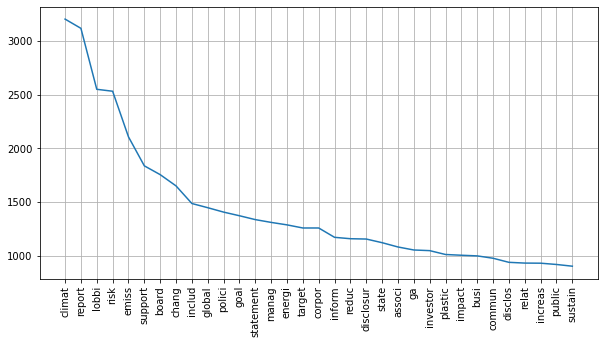

In [68]:
#now plot, line plot!

myList = dc.items()
#myList = sorted(myList) 
x, y = zip(*myList) 

plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.grid()
plt.savefig('wordcount.png')
plt.show();

#### Optional comparisons. (Find a way to combine for more inclusive results..)

In [70]:
#can compare portland to snowball stemmer, repeat the above steps to compare! Have fun!
X_snow = cv.fit_transform(corpus_snow)
dtm_snow = pd.DataFrame(X_snow.toarray(), index=indx_label, columns=cv.get_feature_names_out())
#dtm.to_csv('dtm_porter.csv')
dtm_snow

,ab,abandon,abbvi,abil,abil compet,abil compet adapt,abil comprehens,abil comprehens evalu,abl,abl fulli,...,zero limit warm,zero maintain,zero maintain warm,zero net,zero net deforest,zero order,zero order limit,zero pathway,zero scenario,zero target
Adopt stewardship practices to reduce diversified portfolio ESG costs...,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Report on lobbying...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Report on lobbying in line with company values/policy...,0,0,12,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Adopt GHG reduction targets...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Adopt GHG reduction targets...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Report on supply chain deforestation impacts...,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Report on pay disparity...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Report on lobbying...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Nominate human rights expert to board...,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
#can compare portland to Lancaster stemmer, repeat the above steps to compare! Have fun!
X_lanc = cv.fit_transform(corpus_lanc)
dtm_lanc = pd.DataFrame(X_lanc.toarray(), index=indx_label, columns=cv.get_feature_names_out())
#dtm.to_csv('dtm_porter.csv')
dtm_lanc

,ab,abandon,abbvy,abl,abl compet,abl compet adapt,abl comprehend,abl comprehend evalu,abl ful,abl ful evalu,...,zero limit warm,zero maintain,zero maintain warm,zero net,zero net deforest,zero ord,zero ord limit,zero pathway,zero scenario,zero target
Adopt stewardship practices to reduce diversified portfolio ESG costs...,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Report on lobbying...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Report on lobbying in line with company values/policy...,0,0,12,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Adopt GHG reduction targets...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Adopt GHG reduction targets...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Report on supply chain deforestation impacts...,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Report on pay disparity...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Report on lobbying...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Nominate human rights expert to board...,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Sentiment Score

Assigning positive negative or nuetral scores to the documents

In [72]:
corpus_list = list(df.porter)
corpus_list[0] #check to see the corpus is formatted correctly (do not apply sent score to each letter!)

'sustain report ceo mike roman state commit leader sustain review report reveal address mani environment concern commit limit exampl activ three trade associ work comprehens u polici address climat chang appear commit meet scienc base target initi degre celsiu world fail receiv grade cdp wide use respect climat rate belgian regul recent order stop pfa product recent blood sampl taken peopl near plant show elev level pfa appear address sustain issu pursuit optim financi return sustain report state prioriti comprehens manag enterpris risk ethic tone govern process clear role respons account priorit risk enterpris rather risk environ mean address environment issu threaten abil gener profit risk global commun threaten priorit continu profit conduct threaten environ creat risk profit come expens environ bad trade diversifi reli broad econom growth achiev financi object strategi increas financi return threaten global gdp counter interest potenti drag gdp creat environment cost directli reduc

In [ ]:
#run the sentiment analyzer--takes a long time
analyzer = SentimentIntensityAnalyzer() 
score = analyzer.polarity_scores(corpus_list)
print(score) #earlier results, for comparison through iterations {'neg': 0.074, 'neu': 0.795, 'pos': 0.131, 'compound': 1.0} on June 17 all 923 docs
# later results on list(df.porter) = {'neg': 0.076, 'neu': 0.794, 'pos': 0.131, 'compound': 1.0}


In [63]:
#put scores into df for interpretation. Here, the scores are based on 'whereas'. Should be based on stemmed columns!
#RETURN AND FIX THIS!
df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in df['porter']]
df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in df['porter']]
df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in df['porter']]
df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in df['porter']]
df

,status,title,organization,filed_by,year,whereas,preprocessed,filtered,tokenized,porter,lancaster,snowball,compound,neg,neu,pos
0,Filed,Adopt stewardship practices to reduce diversif...,3M Co.,The Shareholder Commons,2022,"In our Company’s 2021 Sustainability Report, C...",In our Company s Sustainability Report C...,Company Sustainability Report CEO Mike Roman s...,"[Company, Sustainability, Report, CEO, Mike, R...",compani sustain report ceo mike roman state co...,company sustain report ceo mik rom stat commit...,compani sustain report ceo mike roman state co...,0.9697,0.107,0.746,0.147
1,Vote,Report on lobbying,Abbott Laboratories,Unitarian Universalist Association,2022,We believe in full disclosure of Abbott Labora...,We believe in full disclosure of Abbott Labora...,believe disclosure Abbott Laboratories Abbott ...,"[believe, disclosure, Abbott, Laboratories, Ab...",believ disclosur abbott laboratori abbott dire...,believ disclos abbot lab abbot direct indirect...,believ disclosur abbott laboratori abbott dire...,0.5205,0.115,0.780,0.105
2,Vote,Report on lobbying in line with company values...,AbbVie Inc.,As You Sow,2022,The political expenditures of AbbVie Inc. appe...,The political expenditures of AbbVie Inc appe...,political expenditures AbbVie Inc appear misal...,"[political, expenditures, AbbVie, Inc, appear,...",polit expenditur abbvi inc appear misalign pub...,polit expendit abbvy int appear misalign publ ...,polit expenditur abbvi inc appear misalign pub...,0.9956,0.031,0.801,0.168
3,Withdrawn: Commitment,Adopt GHG reduction targets,Air Products & Chemicals Inc.,The Nathan Cummings Foundation,2022,Resolved:\nShareholders request Air Products a...,Resolved Shareholders request Air Products ad...,Air Products address risks opportunities prese...,"[Air, Products, address, risks, opportunities,...",air product address risk opportun present clim...,air produc address risk opportun pres clim cha...,air product address risk opportun present clim...,0.9545,0.013,0.830,0.156
4,Withdrawn: Strategic,Adopt GHG reduction targets,Allegheny Technologies Inc.,As You Sow,2022,The increasing rate and number of climate rela...,The increasing rate and number of climate rela...,increasing rate number climate related disaste...,"[increasing, rate, number, climate, related, d...",increas rate number climat relat disast affect...,increas rat numb clim rel disast affect socy c...,increas rate number climat relat disast affect...,0.2960,0.054,0.883,0.064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,Vote,Report on supply chain deforestation impacts,"Mondelez International, Inc.",SumOfUS,2019,Resolved:\nShareholders request that Mondelēz ...,Resolved Shareholders request that Mondel z I...,Mondel z International Inc Mondelez report ann...,"[Mondel, z, International, Inc, Mondelez, repo...",mondel z intern inc mondelez report annual ini...,mondel z intern int mondelez report an init ma...,mondel z intern inc mondelez report annual ini...,0.2263,0.084,0.817,0.099
938,Vote,Report on pay disparity,"Mondelez International, Inc.",AFL-CIO,2019,Resolved: Shareholders of Mondelez Internation...,Resolved Shareholders of Mondelez Internation...,Mondelez International Inc Company Compensatio...,"[Mondelez, International, Inc, Company, Compen...",mondelez intern inc compani compens committe b...,mondelez intern int company compens commit boa...,mondelez intern inc compani compens committe b...,-0.3626,0.071,0.885,0.044
939,Vote,Report on lobbying,Morgan Stanley,"Boston Common Asset Management, LLC",2019,we believe in full disclosure of Morgan Stanle...,we believe in full disclosure of Morgan Stanle...,believe disclosure Morgan Stanley direct indir...,"[believe, disclosure, Morgan, Stanley, direct,...",believ disclosur morgan stanley direct indirec...,believ disclos morg stanley direct indirect lo...,believ disclosur morgan stanley direct indirec...,-0.0275,0.089,0.851,0.060
940,Vote,Nominate human rights expert to board,"Motorol

In [66]:
df.to_csv('sent_score_df.csv')

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

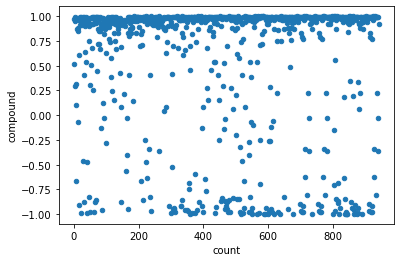

In [64]:
df['count'] = df.index+1
plt = df.plot(x ='count', y='compound', kind = 'scatter')
plt.savefig('sentiment.png')

### (Attempting to get) NMF coherence score

In [116]:
#https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45
#and 
#https://datascience.oneoffcoder.com/topic-modeling-gensim.html

from gensim.corpora import Dictionary

# Use Gensim's NMF to get the best num of topics via coherence score
#texts = porter_list
#Tokenize the sentence into words
tokens = [word for word in porter_str.split()]

top_terms = np.array(tokens)#[top_term_indices]

#Create dictionary
dictionary = corpora.Dictionary([top_terms])
print(dictionary)


# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
#dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(term) for term in top_terms]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 75 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

Dictionary<6975 unique tokens: ['a', 'aa', 'aacd', 'aag', 'aar']...>


TypeError: doc2bow expects an array of unicode tokens on input, not a single string

In [117]:
top_terms

array(['compani', 'sustain', 'report', ..., 'includ', 'trade', 'associ'],
      dtype='<U31')

In [108]:
dataset = ['driving car ',
           'drive car carefully',
           'student and university']

# be sure to split sentence before feed into Dictionary
dataset = [d.split() for d in dataset]

vocab = Dictionary(dataset)

list

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel


In [98]:
#lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)
#corpus_lsi = lsi_model[corpus_tfidf]
nmf = NMF(20, init = "nndsvda")

cm = CoherenceModel(model=nmf, texts=texts, coherence='c_v')
cm.get_coherence()

AttributeError: 'NMF' object has no attribute 'id2word'

In [ ]:
cm = CoherenceModel(model=lda_model, texts=texts, coherence='c_v')
cm.get_coherence()

## Some next steps:

- In the feature names, some features a combination of multiple words (not bigram, rather missing a space). Find out why...or drop words with a length greather than 2 std dev from the average (stemmed?) word length. 
- Look at coherence score for nmf, find optimal (is it) topic numbers?
- Something is wrong with my merged df
- Look at topics by year
- What story can be told about each topic by year
